In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras

## Analysing Dataset

In [2]:
os.listdir('/kaggle/input/face-recognition-dataset')

['Faces', 'Original Images', 'Dataset.csv']

On examining the dataset, we discover that the `'Faces'` directory contains all the images of many famous personalities in a shuffled order, the `'Original Images'` directory contains images sorted by personalities. The dataset also contains a `'Dataset.csv'`.

In [3]:
data=pd.read_csv('/kaggle/input/face-recognition-dataset/Dataset.csv')
data.head()

,id,label
0,Robert Downey Jr_87.jpg,Robert Downey Jr
1,Lisa Kudrow_64.jpg,Lisa Kudrow
2,Ellen Degeneres_34.jpg,Ellen Degeneres
3,Billie Eilish_3.jpg,Billie Eilish
4,Hrithik Roshan_35.jpg,Hrithik Roshan


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2562 entries, 0 to 2561
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2562 non-null   object
 1   label   2562 non-null   object
dtypes: object(2)
memory usage: 40.2+ KB


In [5]:
labels=np.array(data['label'])
len(labels),labels[:10]

(2562,
 array(['Robert Downey Jr', 'Lisa Kudrow', 'Ellen Degeneres',
        'Billie Eilish', 'Hrithik Roshan', 'Vijay Deverakonda',
        'Tom Cruise', 'Alia Bhatt', 'Elizabeth Olsen', 'Charlize Theron'],
       dtype=object))

In [6]:
unique_labels=np.unique(labels)
len(unique_labels),unique_labels[:10]

(31,
 array(['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt',
        'Amitabh Bachchan', 'Andy Samberg', 'Anushka Sharma',
        'Billie Eilish', 'Brad Pitt', 'Camila Cabello', 'Charlize Theron'],
       dtype=object))

In [7]:
bool_labels=[label==unique_labels for label in labels]
len(bool_labels),bool_labels[0]

(2562,
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False,
        False, False, False, False]))

In [8]:
filenames=['/kaggle/input/face-recognition-dataset/Faces/Faces/'+x for x in data['id']]

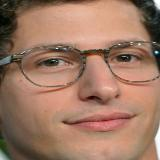

In [9]:
from IPython.display import Image
Image(filenames[42])

## Splitting into train, test and validation data

In [79]:
x=filenames
y=bool_labels

In [80]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

In [81]:
len(x_train),len(y_train),len(x_test),len(y_test)

(1793, 1793, 769, 769)

In [82]:
x_val,x_test,y_val,y_test=train_test_split(x_test,y_test,test_size=0.5)

In [83]:
len(x_val),len(y_val),len(x_test),len(y_test)

(384, 384, 385, 385)

## Preprocessing Data

In [15]:
def process_image(filename,label=None):
    image=tf.io.read_file(filename)
    image=tf.image.decode_jpeg(image,channels=3)
    image=tf.image.resize(image,[224,224])
    image=image/255
    return image,label

In [16]:
def get_batches(x,y=None,test_data=False,val_data=False):
    if test_data:
        print("Creating test data batches...")
        test_data=tf.data.Dataset.from_tensor_slices((tf.constant(x)))
        data_batch=test_data.map(process_image).batch(32)
    elif val_data:
        print("Creating validation data batches...")
        val_data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
        data_batch=val_data.map(process_image).batch(32)
    else:
        print("Creating train data batches...")
        train_data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
        data_batch=train_data.map(process_image).batch(32)
    return data_batch

In [17]:
train_data=get_batches(x_train,y_train)
val_data=get_batches(x_val,y_val,val_data=True)

Creating train data batches...
Creating validation data batches...


In [18]:
train_images,train_labels=next(train_data.as_numpy_iterator())
val_images,val_labels=next(val_data.as_numpy_iterator())

## Creating our Model

In [19]:
def build_model():
    model=tf.keras.models.Sequential([
        keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=96,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.BatchNormalization(),
        keras.layers.Flatten(),
        keras.layers.Dense(units=128,activation='relu'),
        keras.layers.Dense(units=31,activation='softmax')
    ])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics='accuracy'
    )
    
    return model

In [20]:
model=build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 111, 111, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                        

## Creating Callbacks

In [23]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if logs.get('val_accuracy') > 0.6:
            print("Model will stop training now as it's val_accuracy has reached 60%")
            self.model.stop_training=True
callbacks=MyCallback()

In [24]:
early_stopping=tf.keras.callbacks.EarlyStopping()

## Training our Model

In [25]:
history=model.fit(
    x=train_data,
    batch_size=32,
    epochs=50,
    validation_data=val_data,
    validation_batch_size=16,
    validation_freq=1,
    callbacks=[callbacks]
)

Epoch 1/50
57/57 [==============================] - 72s 1s/step - loss: 3.6411 - accuracy: 0.1567 - val_loss: 56.8593 - val_accuracy: 0.0443
Epoch 2/50
57/57 [==============================] - 68s 1s/step - loss: 2.4480 - accuracy: 0.2794 - val_loss: 4.0415 - val_accuracy: 0.2318
Epoch 3/50
57/57 [==============================] - 68s 1s/step - loss: 1.9468 - accuracy: 0.4004 - val_loss: 2.6235 - val_accuracy: 0.3229
Epoch 4/50
57/57 [==============================] - 69s 1s/step - loss: 1.5685 - accuracy: 0.5042 - val_loss: 2.5079 - val_accuracy: 0.3724
Epoch 5/50
57/57 [==============================] - 68s 1s/step - loss: 1.2502 - accuracy: 0.5990 - val_loss: 2.8531 - val_accuracy: 0.4089
Epoch 6/50
57/57 [==============================] - 68s 1s/step - loss: 1.0646 - accuracy: 0.6670 - val_loss: 2.5372 - val_accuracy: 0.3828
Epoch 7/50
57/57 [==============================] - 68s 1s/step - loss: 0.9145 - accuracy: 0.7183 - val_loss: 3.6885 - val_accuracy: 0.3568
Epoch 8/50
57/57 [=

We have achieved 95.43% accuracy and 60.42% val accuracy

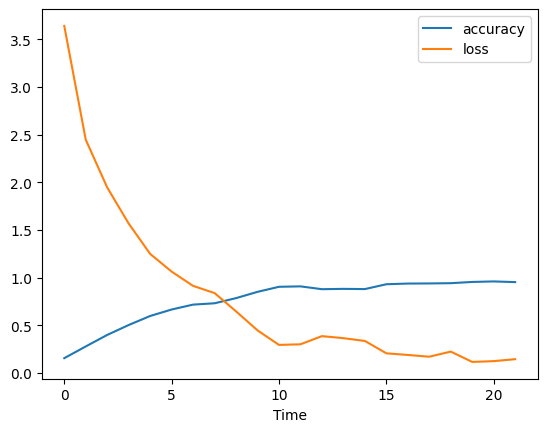

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Time')
plt.legend(['accuracy', 'loss'])
plt.show()

****As seen from the graph, the accuracy keeps increasing towards 1 and the loss keeps decreasing as time passes.****

## Making predictions and Visualising them using Validation dataset

In [37]:
val_images=[]
val_labels=[]
for image,label in val_data.unbatch().as_numpy_iterator():
    val_images.append(image)
    val_labels.append(unique_labels[np.argmax(label)])

In [38]:
val_images[0],val_labels[0]

(array([[[0.02352941, 0.        , 0.        ],
         [0.01904762, 0.        , 0.        ],
         [0.01680672, 0.        , 0.        ],
         ...,
         [0.0061624 , 0.00112041, 0.01568628],
         [0.00392157, 0.        , 0.01568628],
         [0.00392157, 0.        , 0.01568628]],
 
        [[0.0280112 , 0.        , 0.        ],
         [0.0222489 , 0.        , 0.        ],
         [0.01712685, 0.        , 0.        ],
         ...,
         [0.00936372, 0.00272107, 0.01888759],
         [0.00648258, 0.00128051, 0.01824729],
         [0.00392157, 0.        , 0.01568628]],
 
        [[0.0280112 , 0.        , 0.        ],
         [0.02256903, 0.        , 0.        ],
         [0.01656663, 0.        , 0.        ],
         ...,
         [0.01288515, 0.00504202, 0.02080837],
         [0.01048418, 0.00384153, 0.02000799],
         [0.00728291, 0.0022409 , 0.01680672]],
 
        ...,
 
        [[0.41008398, 0.41008398, 0.41792712],
         [0.40560216, 0.40560216, 0.41344

In [42]:
preds=model.predict(val_data,verbose=1)

12/12 [==============================] - 4s 320ms/step


In [44]:
def plot_preds(preds,labels,images,n=42):
    pred_prob,truth_label,image=preds[n],labels[n],images[n]
    pred_label=unique_labels[np.argmax(pred_prob)]
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    if pred_label==truth_label:
        color='green'
    else:
        color='red'
    plt.title('{} {:2.0f}% {}'.format(pred_label,np.max(pred_prob)*100,truth_label),color=color)

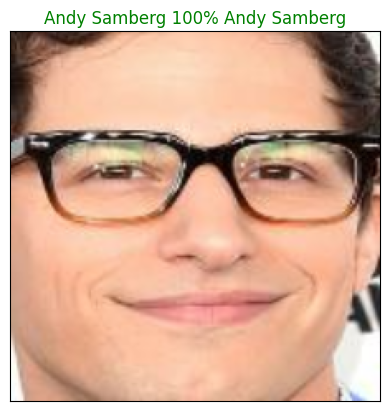

In [46]:
plot_preds(preds,val_labels,val_images,42)

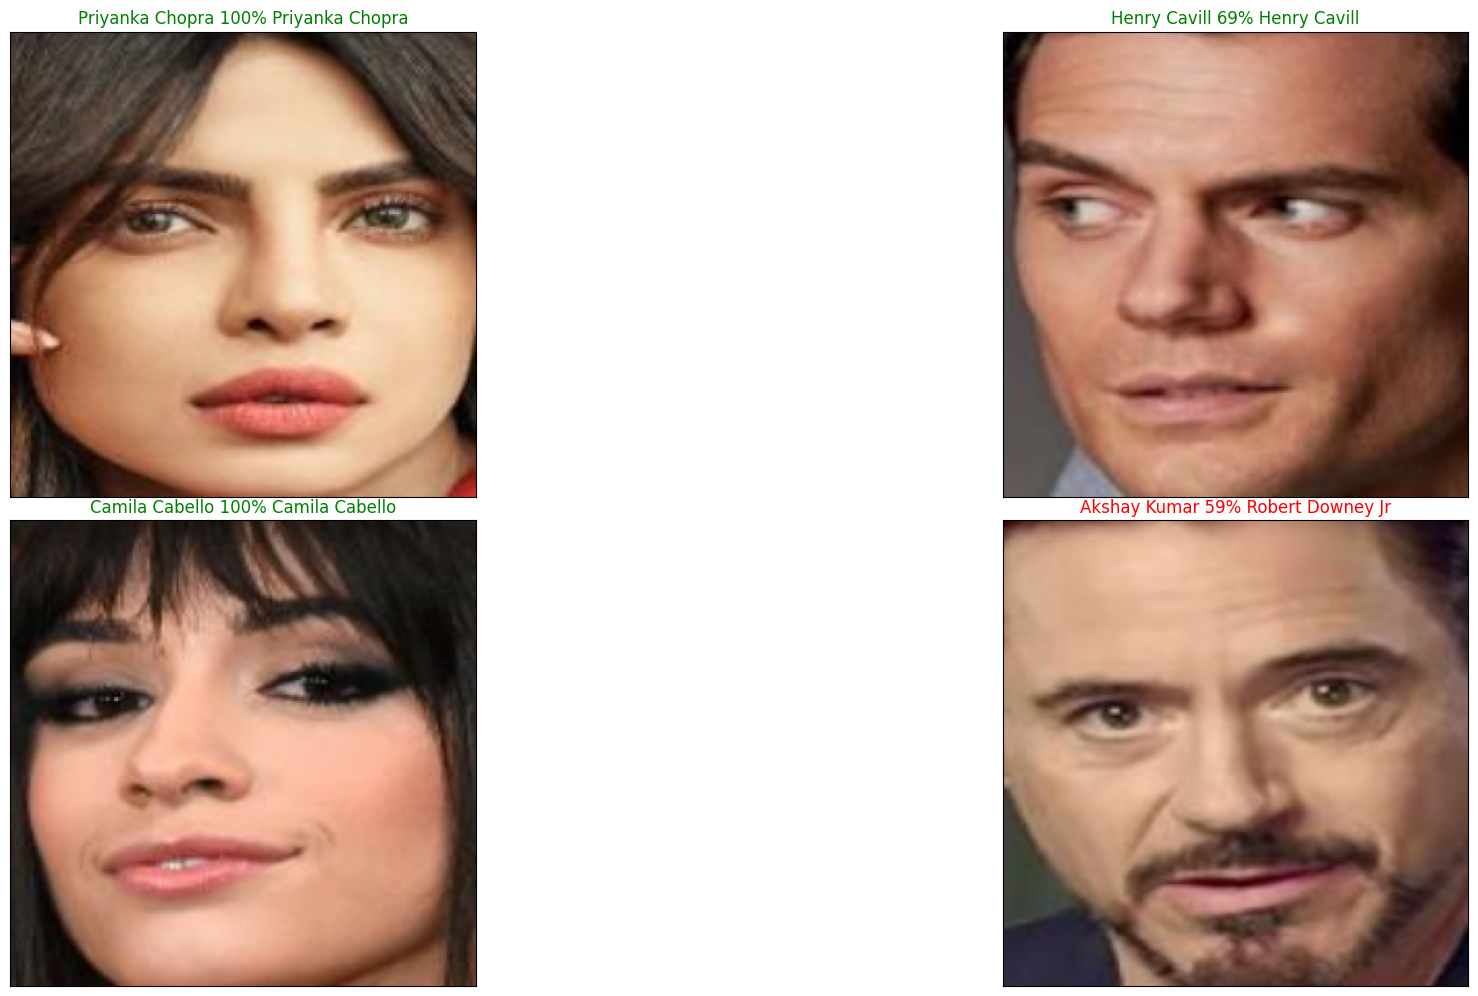

In [49]:
i_mul=20
rows=2
cols=2
num_images=rows*cols
plt.figure(figsize=(10*cols,5*rows))
for i in range(num_images):
    plt.subplot(rows,2*cols,2*i+1)
    plot_preds(preds,val_labels,val_images,i+i_mul)
plt.tight_layout(h_pad=1.0)
plt.show()

## Making predictions on Test Dataset

In [85]:
x_test[:10]

['/kaggle/input/face-recognition-dataset/Faces/Faces/Ellen Degeneres_53.jpg',
 '/kaggle/input/face-recognition-dataset/Faces/Faces/Tom Cruise_33.jpg',
 '/kaggle/input/face-recognition-dataset/Faces/Faces/Dwayne Johnson_31.jpg',
 '/kaggle/input/face-recognition-dataset/Faces/Faces/Ellen Degeneres_47.jpg',
 '/kaggle/input/face-recognition-dataset/Faces/Faces/Ellen Degeneres_6.jpg',
 '/kaggle/input/face-recognition-dataset/Faces/Faces/Vijay Deverakonda_94.jpg',
 '/kaggle/input/face-recognition-dataset/Faces/Faces/Elizabeth Olsen_41.jpg',
 '/kaggle/input/face-recognition-dataset/Faces/Faces/Kashyap_5.jpg',
 '/kaggle/input/face-recognition-dataset/Faces/Faces/Zac Efron_55.jpg',
 '/kaggle/input/face-recognition-dataset/Faces/Faces/Robert Downey Jr_17.jpg']

In [86]:
test_data=get_batches(x_test,test_data=True)

Creating test data batches...


In [87]:
test_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), NoneTensorSpec())>

In [88]:
test_preds=model.predict(test_data,verbose=1)

13/13 [==============================] - 4s 292ms/step


In [89]:
test_preds.shape

(385, 31)

In [90]:
test_pred_labels=[unique_labels[np.argmax(test_preds[i])] for i in range(len(test_preds))]
test_pred_labels[:10]

['Ellen Degeneres',
 'Tom Cruise',
 'Dwayne Johnson',
 'Ellen Degeneres',
 'Ellen Degeneres',
 'Vijay Deverakonda',
 'Elizabeth Olsen',
 'Marmik',
 'Zac Efron',
 'Brad Pitt']